In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join('..')))
sys.path.insert(0, '/home/henry/projects/SpectralVAEGAN/src/core/')
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('/home/henry/projects/SpectralVAEGAN/src/applications'),'..')))
import numpy as np
import pickle
import numpy as np
from functools import partial
import tensorflow as tf

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Lambda, Subtract, Dense
from keras.layers.merge import _Merge
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.datasets import mnist

import train
import costs
from data import predict_with_K_fn
from layer import stack_layers
from util import LearningHandler, make_layer_list, train_gen, get_scale

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/home/henry/henry/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/henry/henry/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/henry/henry/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/henry/henry/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/henry/henry/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/henry/henry/lib/python3.5/importlib/_b

In [2]:
def predict_with_K_fn(K_fn, x, bs=1000):
    '''
    Convenience function: evaluates x by K_fn(x), where K_fn is
    a Keras function, by batches of size 1000.
    '''
    if not isinstance(x, list):
        x = [x]
    num_outs = len(K_fn.outputs)
    y = [np.empty((len(x[0]), output_.get_shape()[1])) for output_ in K_fn.outputs]
    recon_means = []
    for i in range(int(x[0].shape[0]/bs + 1)):
        x_batch = []
        for x_ in x:
            x_batch.append(x_[i*bs:(i+1)*bs])
        temp = K_fn(x_batch)
        for j in range(num_outs):
            y[j][i*bs:(i+1)*bs] = temp[j]

    return y

In [3]:
def generate_loop(n=1200, train_set_fraction=.8):
    t = np.linspace(0, 2*np.pi, num=n)
    
    # generate all three coordinates
    x = np.empty((n, 3))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(2*t)
    x[:,2] = np.sin(3*t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_line(n=1200, train_set_fraction=.8):
    pts_per_cluster = int(n / 2)
    x1 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x2 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x = np.concatenate([x1, x2], axis=1)
    
    # generate labels
#     y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)
    y = x1
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_gaussians(n=1200, n_clusters=2, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / n_clusters)
    r = 1
    
    clusters = []
    
    for x in np.linspace(0, 1, num=n_clusters):
        clusters.append(np.random.normal(x, noise_sigma, size=(pts_per_cluster, 2)))

    # combine clusters
    x = np.concatenate(clusters, axis=0)
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_cc(n=1200, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / 2)
    r = 1

    # generate clusters
    theta1 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)
    theta2 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)

    cluster1 = np.concatenate((np.cos(theta1) * r, np.sin(theta1) * r), axis=1)
    cluster2 = np.concatenate((np.cos(theta2) * r, np.sin(theta2) * r), axis=1)

    # shift and reverse cluster 2
    cluster2[:, 0] = -cluster2[:, 0] + 0.5
    cluster2[:, 1] = -cluster2[:, 1] - 1

    # combine clusters
    x = np.concatenate((cluster1, cluster2), axis=0)

    # add noise to x
    x = x + np.random.randn(x.shape[0], 2) * noise_sigma
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

In [4]:
def plot(x, y=None, x2=None, y2=None):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    %matplotlib inline
    n = x.shape[1]
    if n == 1:
        plt.scatter(np.zeros((n,)), x[:,1], c=y, marker='x')
        if x2 is not None:
            plt.scatter(np.zeros((n,)), x2[:,1], c=y2, s=10)
    if n == 3:
        %matplotlib notebook
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x[:,0], x[:,1], x[:,2], c=y, marker='x')
        if x2 is not None:
            ax.scatter(x2[:,0], x2[:,1], x2[:,2], c=y2, s=10)
    elif n == 784:
        n_imgs = 10
        # num = 7
        # sub = y == num
        sub = y == y
        for i in range(n_imgs):
            idx = np.random.randint(len(x[sub]))
            if x2 is not None:
                plt.subplot(1,2,1)
                plt.imshow(x2[sub][idx].reshape(28, 28))
            plt.subplot(1,2,2)
            plt.imshow(x[sub][idx].reshape(28, 28))
            plt.figure()
    else:
        plt.scatter(x[:,0], x[:,1], c=y, marker='x')
        if x2 is not None:
            plt.scatter(x2[:,0], x2[:,1], c=y2, s=10)

IMPORTANT: max 1.0, min 0.0005002501250625312


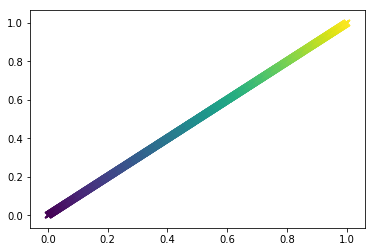

In [ ]:
dataset = 'line'

if dataset == 'mnist':
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255
    latent_dim = 10
elif dataset == 'gaussians':
    (x_train, y_train), (x_test, y_test) = generate_gaussians(n=2000, n_clusters=2, train_set_fraction=0.85)
    latent_dim = 4
elif dataset == 'line':
    (x_train, y_train), (x_test, y_test) = generate_line(n=2000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=2000, train_set_fraction=0.85)
    latent_dim = 2

# normalize to between -1 and 1
# m, M = np.min(x_train), np.max(x_train)
# x_train, x_test = x_train / (M - m) * 2 - 1, x_test / (M - m) * 2 - 1
print('IMPORTANT: max {}, min {}'.format(np.max(x_train), np.min(x_train)))

arch = [
    {'type': 'relu', 'size': 1024},
    {'type': 'relu', 'size': 1024},
    {'type': 'relu', 'size': 512},
    {'type': 'linear', 'size': latent_dim},
    ]

plot(x_train, y_train)

In [ ]:
class SpectralNet:
    def __init__(self, inputs, arch, spec_reg, y_true, y_train_labeled_onehot,
            n_clusters, affinity, scale_nbr, n_nbrs, batch_sizes,
            siamese_net=None, x_train=None, have_labeled=False):
        self.y_true = y_true
        self.y_train_labeled_onehot = y_train_labeled_onehot
        self.inputs = inputs
        self.batch_sizes = batch_sizes
        # generate layers
        self.layers = make_layer_list(arch[:-1], 'spectral', spec_reg)
        self.layers += [
                  {'type': 'tanh',
                   'size': n_clusters,
                   'l2_reg': spec_reg,
                   'name': 'spectral_{}'.format(len(arch)-1)},
                  {'type': 'Orthonorm', 'name':'orthonorm'}
                  ]

        # create spectralnet
        self.outputs = stack_layers(self.inputs, self.layers)
        self.net = Model(inputs=self.inputs['Unlabeled'], outputs=self.outputs['Unlabeled'])

        # DEFINE LOSS

        # generate affinity matrix W according to params
        if affinity == 'siamese':
            input_affinity = tf.concat([siamese_net.outputs['A'], siamese_net.outputs['Labeled']], axis=0)
            x_affinity = siamese_net.predict(x_train, batch_sizes)
        elif affinity in ['knn', 'full']:
            input_affinity = tf.concat([self.inputs['Unlabeled'], self.inputs['Labeled']], axis=0)
            x_affinity = x_train

        # calculate scale for affinity matrix
        scale = get_scale(x_affinity, self.batch_sizes['Unlabeled'], scale_nbr)

        # create affinity matrix
        if affinity == 'full':
            W = costs.full_affinity(input_affinity, scale=scale)
        elif affinity in ['knn', 'siamese']:
            W = costs.knn_affinity(input_affinity, n_nbrs, scale=scale, scale_nbr=scale_nbr)

        # if we have labels, use them
        if have_labeled:
            # get true affinities (from labeled data)
            W_true = tf.cast(tf.equal(costs.squared_distance(y_true), 0),dtype='float32')

            # replace lower right corner of W with W_true
            unlabeled_end = tf.shape(self.inputs['Unlabeled'])[0]
            W_u = W[:unlabeled_end, :]                  # upper half
            W_ll = W[unlabeled_end:, :unlabeled_end]    # lower left
            W_l = tf.concat((W_ll, W_true), axis=1)      # lower half
            W = tf.concat((W_u, W_l), axis=0)

            # create pairwise batch distance matrix self.Dy
            self.Dy = costs.squared_distance(tf.concat([self.outputs['Unlabeled'], self.outputs['Labeled']], axis=0))
        else:
            self.Dy = costs.squared_distance(self.outputs['Unlabeled'])

        # define loss
        self.loss = K.sum(W * self.Dy) / (2 * batch_sizes['Unlabeled'])

        # create the train step update
        self.learning_rate = tf.Variable(0., name='spectral_net_learning_rate')
        self.train_step = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)

        # initialize spectralnet variables
        K.get_session().run(tf.variables_initializer(self.net.trainable_weights))

    def train(self, x_train_unlabeled, x_train_labeled, x_val_unlabeled,
            lr, drop, patience, num_epochs):
        # create handler for early stopping and learning rate scheduling
        self.lh = LearningHandler(
                lr=lr,
                drop=drop,
                lr_tensor=self.learning_rate,
                patience=patience)

        losses = np.empty((num_epochs,))
        val_losses = np.empty((num_epochs,))

        # begin spectralnet training loop
        self.lh.on_train_begin()
        i = 0
        for i in range(num_epochs):
            # train spectralnet
            losses[i] = train.train_step(
                    return_var=[self.loss],
                    updates=self.net.updates + [self.train_step],
                    x_unlabeled=x_train_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    batch_sizes=self.batch_sizes,
                    x_labeled=x_train_labeled,
                    y_labeled=self.y_train_labeled_onehot,
                    batches_per_epoch=100)[0]

            # get validation loss
            val_losses[i] = train.predict_sum(
                    self.loss,
                    x_unlabeled=x_val_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    x_labeled=x_train_unlabeled[0:0],
                    y_labeled=self.y_train_labeled_onehot,
                    batch_sizes=self.batch_sizes)

            # do early stopping if necessary
            if self.lh.on_epoch_end(i, val_losses[i]):
                print('STOPPING EARLY')
                break

            # print training status
            print("Epoch: {}, loss={:2f}, val_loss={:2f}".format(i, losses[i], val_losses[i]))

        return losses[:i+1], val_losses[:i+1]

    def predict(self, x):
        # test inputs do not require the 'Labeled' input
        inputs_test = {'Unlabeled': self.inputs['Unlabeled'], 'Orthonorm': self.inputs['Orthonorm']}
        return train.predict(
                    self.outputs['Unlabeled'],
                    x_unlabeled=x,
                    inputs=inputs_test,
                    y_true=self.y_true,
                    x_labeled=x[0:0],
                    y_labeled=self.y_train_labeled_onehot[0:0],
                    batch_sizes=self.batch_sizes)

In [ ]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class SVG:
    def __init__(self, inputs, spectralnet, orig_dim, latent_dim=2):
        from keras.layers import Input, Dense
        optimizer = 'adam' #RMSprop(lr=0.00005)
        self.input = inputs['Unlabeled']
        self.orig_dim = orig_dim
        
        # initialize losses:
        self.gen_loss = []
        self.disc_loss = []
        self.vae_loss = []
        
        if spectralnet is not None:
            x = self.copy_spectralnet(spectralnet)
        else:
            self.latent_dim = latent_dim
            x = self.input

        # create encoder
        x_enc = self.build_encoder(x)
        self.encoder = Model(inputs=self.input, outputs=x_enc)

        # create decoder
        x_recon = self.build_decoder(x_enc)
        self.decoder = Model(inputs=self.input, outputs=x_recon)
        self.x_recon = x_recon
        
        # create critic
        x_critic, x_critic_interm, x_critic_input = self.build_critic(input_shape=(orig_dim,))
        self.critic, self.critic_interm = Model(x_critic_input, x_critic), Model(x_critic_input, x_critic_interm)
        
        ######################################
        #                                        
        # build computation graph for critic
        #                                        
        ######################################
        self.encoder.trainable = False
        self.decoder.trainable = False
        self.critic.trainable = True
        
        # fake example
        fake_sample = x_recon
        
        fake = self.critic(fake_sample)
        valid = self.critic(self.input)
        
        # construct weighted average between real and fake images
        interpolated_sample = RandomWeightedAverage()([self.input, fake_sample])
        # determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_sample)

        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_sample)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=self.input,
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        
        #######################################
        #                                        
        # build computation graph for generator
        #                                        
        #######################################

        # For the generator we freeze the critic's layers
        self.encoder.trainable = False
        self.decoder.trainable = True
        self.critic.trainable = False

        # Discriminator determines validity
        valid = self.critic(x_recon)
        # Defines generator model
        self.generator_model = Model(self.input, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)

        #######################################
        #                                        
        # build computation graph for VAE
        #                                        
        #######################################
        
        # For the VAE we freeze the critic's layers
        self.encoder.trainable = True
        self.decoder.trainable = True
        self.critic.trainable = False
        
#         x_interm = self.critic_interm(x_recon)
#         x_interm_orig = self.critic_interm(self.input)
        x_interm = x_recon
        x_interm_orig = self.input
        
        from keras.losses import mse
        def vae_loss(_, __):
            # alpha is what we want the variances to be (usually 1, but we want it smaller)
            alpha = 0.5
            alpha = float(alpha)
            reconstruction_loss = K.sum(mse(x_interm, x_interm_orig), axis=-1) * self.orig_dim
            kl_loss = -1 + np.log(alpha) - self.sigma + K.exp(self.sigma)/alpha
            kl_loss = K.sum(kl_loss, axis=-1) * 0.5
            vae_loss = K.mean(reconstruction_loss + kl_loss)
            return vae_loss
        
        self.vae = Model(inputs=self.input, outputs=x_interm)
        self.vae.compile(optimizer=optimizer, loss=vae_loss)
        
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)
        
    def build_critic(self, input_shape):
        x = x_input = Input(shape=input_shape)
        x = Dense(256, input_shape=input_shape, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        x = x_interm = Dense(32, name='interm_layer', activation='relu')(x)
        x = Dense(1, activation='linear')(x)
        
        return x, x_interm, x_input
        
    def build_decoder(self, x):
        if not hasattr(self, 'decoder_layers'):
            self.decoder_layers = []
            self.decoder_layers.append(Dense(1024, activation='relu'))
            self.decoder_layers.append(Dense(256, activation='relu'))
            self.decoder_layers.append(Dense(256, activation='relu'))
            # last layer of decoder / generator is always tanh (LINEAR because of WASSERSTEIN LOSS)
            self.decoder_layers.append(Dense(self.orig_dim, activation='linear'))
            
        for l in self.decoder_layers:
            x = l(x)
        
        return x
        
    def build_encoder(self, x_input):
        if not hasattr(self, 'encoder_layers'):
            self.encoder_layers = []
            self.encoder_layers.append(Dense(256, activation='relu'))
            self.encoder_layers.append(Dense(256, activation='relu'))
            self.encoder_layers.append(Dense(1024, activation='relu'))
            self.encoder_layers.append(Dense(self.latent_dim, activation='linear'))
        
        x = x_input
        for l in self.encoder_layers:
            x = l(x)

        # option 1
        self.sigma = sigma = x
        self.mu = mu = x_input
        self.x_enc = Lambda(self.sampling, output_shape=(self.latent_dim,), name='z')([mu, sigma])
        self.encoder = Model(self.input, [self.x_enc])
        self.log_variances = Model(self.input, sigma)
        
        return self.x_enc
        
    def copy_spectralnet(self, spectralnet):
        xs = [self.input]
        layers = []
        for l in spectralnet.net.layers[1:-1]:
            w = l.get_weights()
            n, m = w[0].shape
            if hasattr(l, 'activation'):
                act = l.activation
            new_l = Dense(m, activation=act, input_shape=(n,), weights=w)
            new_l.trainable = False
            xs.append(new_l(xs[-1]))
            layers.append(new_l)

        pre_x = xs[-1]
        # add orthonorm layer
        sess = K.get_session()
        with tf.variable_scope('', reuse=True):
            v = tf.get_variable("ortho_weights_store")
        ows = sess.run(v)
        t_ows = K.variable(ows)
        l = Lambda(lambda x: K.dot(x, t_ows))
        l.trainable = False
        xs.append(l(xs[-1]))
        layers.append(l)

        x = xs[-1]

        self.sn = Model(inputs=self.input, outputs=x)

        self.latent_dim = int(x.get_shape()[1])
        if self.latent_dim != latent_dim:
            print("""warning, spectralnet's latent_dim={} 
            and provided latent_dim={} do not match, 
            defaulting to spectralnet's!""".format(self.latent_dim, latent_dim))
            
        return x

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        output = z_mean + K.exp(0.5 * z_log_var) * epsilon
        return output

    def generate_from_samples(self, x):
        get_fn = K.function([self.input], [self.x_recon])
        x_recon = predict_with_K_fn(get_fn, x)[0]
        return x_recon
#         return self.decoder.predict(x)

    def train(self, xy_train, xy_val, epochs=1, batch_size=128, patience=5):
        x_train, y_train = xy_train
        x_val, y_val = xy_val
        earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')
        val_data = list((x_val, x_val))

        self.vae.fit(x=x_train,
                y=x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=val_data,
                # callbacks=[earlystop, pe],
                callbacks=[earlystop],
                verbose=2)
        
    def train_gan(self, X_train, batch_size=128, epochs=10, n_critic=5, n_vae=5, sample_interval=1):
        # Adversarial ground truths
            valid = -np.ones((batch_size, 1))
            fake =  np.ones((batch_size, 1))
            dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
            d_loss = g_loss = vae_loss = 0
            for epoch in range(epochs):

#                 for _ in range(n_critic):

#                     # ---------------------
#                     #  Train Discriminator
#                     # ---------------------

#                     # Select a random batch of samples
#                     idx = np.random.randint(0, X_train.shape[0], batch_size)
#                     samples = X_train[idx]
#                     # Train the critic
#                     d_loss = self.critic_model.train_on_batch(samples,
#                                                                     [valid, fake, dummy])
#                     self.disc_loss.append(d_loss)
                    
#                 # ---------------------
#                 #  Train Generator
#                 # ---------------------
#                 idx = np.random.randint(0, X_train.shape[0], batch_size)
#                 samples = X_train[idx]
#                 g_loss = self.generator_model.train_on_batch(samples, valid)
#                 self.gen_loss.append(g_loss)
                
                
                #######################
                #
                # Train VAE
                #
                #######################
                
                for _ in range(n_vae):

                    # ---------------------
                    #  Train Discriminator
                    # ---------------------

                    # Select a random batch of samples
                    idx = np.random.randint(0, X_train.shape[0], batch_size)
                    samples = X_train[idx]
                    vae_loss = self.vae.train_on_batch(samples, samples)
                    self.vae_loss.append(vae_loss)

                # Plot the progress
                print ("{} [D loss: {}] [G loss: {}] [VAE loss: {}]".format(epoch, d_loss, g_loss, vae_loss))
                
    def generate(self, num_gen=10):
        noise = np.random.normal(0, 1, (num_gen, self.latent_dim))
        return self.decoder.predict(noise)
        

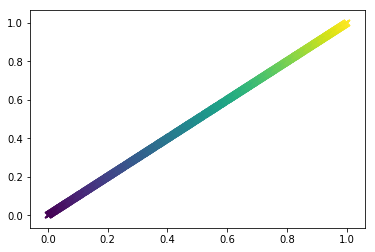

In [ ]:
split = int(len(x_train)*0.8)
x_train, x_val = x_train[:split], x_train[split:]
y_train, y_val = y_train[:split], y_train[split:]

# plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
plot(x_train, y_train)

In [ ]:
n_clusters = latent_dim

batch_sizes = {
    'Unlabeled': 512,
    'Labeled': 512,
    'Orthonorm': 512,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape,name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape,name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape,name='OrthonormInput'),
    }
spectral_net = SpectralNet(inputs, arch,
            None, y_true, y_train_labeled_onehot,
            n_clusters, 'knn', 2, 2, batch_sizes, None, x_train, len(x_train))

spectral_net.train(
        x_train, np.zeros_like(x_train[0:0]), x_test,
        lr=1e-4, drop=0.1, patience=30, num_epochs=300)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Epoch: 0, loss=0.000030, val_loss=0.000000
Epoch: 1, loss=0.000063, val_loss=0.000000
Epoch: 2, loss=0.000058, val_loss=0.000000
Epoch: 3, loss=0.000055, val_loss=0.000000
Epoch: 4, loss=0.000055, val_loss=0.000000
Epoch: 5, loss=0.000054, val_loss=0.000000
Epoch: 6, loss=0.000053, val_loss=0.000000
Epoch: 7, loss=0.000052, val_loss=0.000000
Epoch: 8, loss=0.000052, val_loss=0.000000
Epoch: 9, loss=0.000052, val_loss=0.000000
Epoch: 10, loss=0.000052, val_loss=0.000000
Epoch: 11, loss=0.000052, val_loss=0.000000
Epoch: 12, loss=0.000052, val_loss=0.000000
Epoch: 13, loss=0.000052, val_loss=0.000000
Epoch: 14, loss=0.000052, val_loss=0.000000
Epoch: 15, loss=0.000051, val_loss=0.000000
Epoch: 16, loss=0.000051, val_loss=0.000000
Epoch: 17, loss=0.000051, val_loss=0.000000
Epoch: 18, loss=0.000051, val_loss=0.000000
Epoch: 19, loss=0.000051, val_loss=0.000000
Epoch: 20, loss=0.000052, val_l

(array([2.97301699e-05, 6.31645516e-05, 5.77896141e-05, 5.48837365e-05,
        5.48700810e-05, 5.37860843e-05, 5.29865197e-05, 5.20718822e-05,
        5.22511229e-05, 5.19556217e-05, 5.19447393e-05, 5.19544102e-05,
        5.16607636e-05, 5.22893016e-05, 5.16793773e-05, 5.11328529e-05,
        5.09341511e-05, 5.12162997e-05, 5.14779015e-05, 5.12534728e-05,
        5.20578853e-05, 5.20926466e-05, 5.20673094e-05, 5.12041515e-05,
        5.13638653e-05, 5.06917200e-05, 5.12480592e-05, 5.16475523e-05,
        5.10778985e-05, 5.18907252e-05, 5.12799056e-05, 5.11374767e-05,
        5.07288898e-05, 4.97293913e-05, 4.92472124e-05, 4.90244859e-05,
        4.94647248e-05, 4.99096031e-05, 4.99871886e-05, 4.98818110e-05,
        4.99219626e-05, 4.96776438e-05, 4.96897981e-05, 4.96952246e-05,
        4.95828714e-05, 4.96489012e-05, 4.94868991e-05, 4.99446913e-05,
        4.94097739e-05, 4.91754340e-05, 4.97526567e-05, 5.01302853e-05,
        4.96025465e-05, 4.95831272e-05, 4.95610819e-05, 4.971525

range of y_pred values: 1.5903455018997192 - -1.2092550992965698


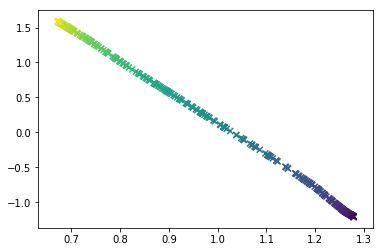

In [ ]:
y_pred = spectral_net.predict(x_test)
plot(y_pred, y_test)
print('range of y_pred values: {} - {}'.format(np.max(y_pred), np.min(y_pred)))

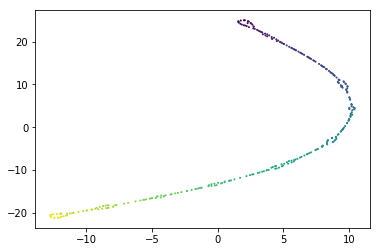

In [ ]:
# # now plot all the dimensions of spectralnet
y_pred_embedded = TSNE().fit_transform(y_pred)
plt.scatter(y_pred_embedded[:,0], y_pred_embedded[:,1], c=y_test, s=1)

In [ ]:
svg = SVG(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[-1], latent_dim=latent_dim)
svg.train_gan(x_train, epochs=2000, n_critic=5, n_vae=20)
x_gen = svg.generate_from_samples(x_train)
plot(x_gen, y_train)

0 [D loss: 0] [G loss: 0] [VAE loss: 5.669891357421875]
1 [D loss: 0] [G loss: 0] [VAE loss: 3.557072401046753]
2 [D loss: 0] [G loss: 0] [VAE loss: 2.364872932434082]
3 [D loss: 0] [G loss: 0] [VAE loss: 2.0501158237457275]
4 [D loss: 0] [G loss: 0] [VAE loss: 1.9000051021575928]
5 [D loss: 0] [G loss: 0] [VAE loss: 1.7930970191955566]
6 [D loss: 0] [G loss: 0] [VAE loss: 1.7726120948791504]
7 [D loss: 0] [G loss: 0] [VAE loss: 1.7514935731887817]
8 [D loss: 0] [G loss: 0] [VAE loss: 1.914421558380127]
9 [D loss: 0] [G loss: 0] [VAE loss: 1.8454270362854004]
10 [D loss: 0] [G loss: 0] [VAE loss: 1.849757432937622]
11 [D loss: 0] [G loss: 0] [VAE loss: 1.7549457550048828]
12 [D loss: 0] [G loss: 0] [VAE loss: 1.9471497535705566]
13 [D loss: 0] [G loss: 0] [VAE loss: 1.7906129360198975]
14 [D loss: 0] [G loss: 0] [VAE loss: 1.763059139251709]
15 [D loss: 0] [G loss: 0] [VAE loss: 1.795743703842163]
16 [D loss: 0] [G loss: 0] [VAE loss: 1.8531193733215332]
17 [D loss: 0] [G loss: 0] [VAE

142 [D loss: 0] [G loss: 0] [VAE loss: 2.0098111629486084]
143 [D loss: 0] [G loss: 0] [VAE loss: 1.8361401557922363]
144 [D loss: 0] [G loss: 0] [VAE loss: 1.9030406475067139]
145 [D loss: 0] [G loss: 0] [VAE loss: 1.6213717460632324]
146 [D loss: 0] [G loss: 0] [VAE loss: 2.0472066402435303]
147 [D loss: 0] [G loss: 0] [VAE loss: 1.8904359340667725]
148 [D loss: 0] [G loss: 0] [VAE loss: 1.7959051132202148]
149 [D loss: 0] [G loss: 0] [VAE loss: 1.7606133222579956]
150 [D loss: 0] [G loss: 0] [VAE loss: 1.6956381797790527]
151 [D loss: 0] [G loss: 0] [VAE loss: 1.8386625051498413]
152 [D loss: 0] [G loss: 0] [VAE loss: 1.9002611637115479]
153 [D loss: 0] [G loss: 0] [VAE loss: 1.9641976356506348]
154 [D loss: 0] [G loss: 0] [VAE loss: 1.7857688665390015]
155 [D loss: 0] [G loss: 0] [VAE loss: 1.7482776641845703]
156 [D loss: 0] [G loss: 0] [VAE loss: 2.0294840335845947]
157 [D loss: 0] [G loss: 0] [VAE loss: 1.8315781354904175]
158 [D loss: 0] [G loss: 0] [VAE loss: 1.778516411781311

282 [D loss: 0] [G loss: 0] [VAE loss: 1.8275504112243652]
283 [D loss: 0] [G loss: 0] [VAE loss: 2.177511215209961]
284 [D loss: 0] [G loss: 0] [VAE loss: 1.799926519393921]
285 [D loss: 0] [G loss: 0] [VAE loss: 1.8384249210357666]
286 [D loss: 0] [G loss: 0] [VAE loss: 1.7504271268844604]
287 [D loss: 0] [G loss: 0] [VAE loss: 1.7846286296844482]
288 [D loss: 0] [G loss: 0] [VAE loss: 1.8055254220962524]
289 [D loss: 0] [G loss: 0] [VAE loss: 1.9432159662246704]
290 [D loss: 0] [G loss: 0] [VAE loss: 1.6815484762191772]
291 [D loss: 0] [G loss: 0] [VAE loss: 1.6944864988327026]
292 [D loss: 0] [G loss: 0] [VAE loss: 1.8179327249526978]
293 [D loss: 0] [G loss: 0] [VAE loss: 1.7589201927185059]
294 [D loss: 0] [G loss: 0] [VAE loss: 1.7494069337844849]
295 [D loss: 0] [G loss: 0] [VAE loss: 1.836616039276123]
296 [D loss: 0] [G loss: 0] [VAE loss: 1.6802128553390503]
297 [D loss: 0] [G loss: 0] [VAE loss: 1.7440191507339478]
298 [D loss: 0] [G loss: 0] [VAE loss: 1.9664175510406494]


422 [D loss: 0] [G loss: 0] [VAE loss: 1.6163570880889893]
423 [D loss: 0] [G loss: 0] [VAE loss: 1.858932375907898]
424 [D loss: 0] [G loss: 0] [VAE loss: 1.905656099319458]
425 [D loss: 0] [G loss: 0] [VAE loss: 1.8278847932815552]
426 [D loss: 0] [G loss: 0] [VAE loss: 1.8128838539123535]
427 [D loss: 0] [G loss: 0] [VAE loss: 1.8216984272003174]
428 [D loss: 0] [G loss: 0] [VAE loss: 1.785996437072754]
429 [D loss: 0] [G loss: 0] [VAE loss: 1.7377206087112427]
430 [D loss: 0] [G loss: 0] [VAE loss: 1.7325654029846191]
431 [D loss: 0] [G loss: 0] [VAE loss: 1.646969199180603]
432 [D loss: 0] [G loss: 0] [VAE loss: 1.784805178642273]
433 [D loss: 0] [G loss: 0] [VAE loss: 1.7970991134643555]
434 [D loss: 0] [G loss: 0] [VAE loss: 1.78309965133667]
435 [D loss: 0] [G loss: 0] [VAE loss: 1.8143963813781738]
436 [D loss: 0] [G loss: 0] [VAE loss: 1.6637611389160156]
437 [D loss: 0] [G loss: 0] [VAE loss: 1.7055460214614868]
438 [D loss: 0] [G loss: 0] [VAE loss: 1.7634447813034058]
439 

562 [D loss: 0] [G loss: 0] [VAE loss: 1.6520304679870605]
563 [D loss: 0] [G loss: 0] [VAE loss: 1.9994229078292847]
564 [D loss: 0] [G loss: 0] [VAE loss: 1.6528490781784058]
565 [D loss: 0] [G loss: 0] [VAE loss: 1.6775482892990112]
566 [D loss: 0] [G loss: 0] [VAE loss: 1.7359588146209717]
567 [D loss: 0] [G loss: 0] [VAE loss: 1.7059862613677979]
568 [D loss: 0] [G loss: 0] [VAE loss: 1.5631632804870605]
569 [D loss: 0] [G loss: 0] [VAE loss: 1.8528833389282227]
570 [D loss: 0] [G loss: 0] [VAE loss: 1.859144687652588]
571 [D loss: 0] [G loss: 0] [VAE loss: 1.6731691360473633]
572 [D loss: 0] [G loss: 0] [VAE loss: 1.7262048721313477]
573 [D loss: 0] [G loss: 0] [VAE loss: 1.975089192390442]
574 [D loss: 0] [G loss: 0] [VAE loss: 1.8108642101287842]
575 [D loss: 0] [G loss: 0] [VAE loss: 1.7133640050888062]
576 [D loss: 0] [G loss: 0] [VAE loss: 1.7240711450576782]
577 [D loss: 0] [G loss: 0] [VAE loss: 1.7169402837753296]
578 [D loss: 0] [G loss: 0] [VAE loss: 1.7415703535079956]

703 [D loss: 0] [G loss: 0] [VAE loss: 1.9775158166885376]
704 [D loss: 0] [G loss: 0] [VAE loss: 1.7631022930145264]
705 [D loss: 0] [G loss: 0] [VAE loss: 1.7199246883392334]
706 [D loss: 0] [G loss: 0] [VAE loss: 1.820326566696167]
707 [D loss: 0] [G loss: 0] [VAE loss: 1.9587379693984985]
708 [D loss: 0] [G loss: 0] [VAE loss: 1.7515184879302979]
709 [D loss: 0] [G loss: 0] [VAE loss: 1.8522907495498657]
710 [D loss: 0] [G loss: 0] [VAE loss: 1.7191104888916016]
711 [D loss: 0] [G loss: 0] [VAE loss: 1.9159820079803467]
712 [D loss: 0] [G loss: 0] [VAE loss: 1.7425020933151245]
713 [D loss: 0] [G loss: 0] [VAE loss: 2.04915714263916]
714 [D loss: 0] [G loss: 0] [VAE loss: 1.9309613704681396]
715 [D loss: 0] [G loss: 0] [VAE loss: 1.588740587234497]
716 [D loss: 0] [G loss: 0] [VAE loss: 1.6562378406524658]
717 [D loss: 0] [G loss: 0] [VAE loss: 1.80715012550354]
718 [D loss: 0] [G loss: 0] [VAE loss: 1.9509779214859009]
719 [D loss: 0] [G loss: 0] [VAE loss: 1.9197413921356201]
720

843 [D loss: 0] [G loss: 0] [VAE loss: 1.766756534576416]
844 [D loss: 0] [G loss: 0] [VAE loss: 1.9468510150909424]
845 [D loss: 0] [G loss: 0] [VAE loss: 1.7166764736175537]
846 [D loss: 0] [G loss: 0] [VAE loss: 1.7455112934112549]
847 [D loss: 0] [G loss: 0] [VAE loss: 1.6817350387573242]
848 [D loss: 0] [G loss: 0] [VAE loss: 1.8074445724487305]
849 [D loss: 0] [G loss: 0] [VAE loss: 1.5892208814620972]
850 [D loss: 0] [G loss: 0] [VAE loss: 1.8930400609970093]
851 [D loss: 0] [G loss: 0] [VAE loss: 1.8802918195724487]
852 [D loss: 0] [G loss: 0] [VAE loss: 1.8043479919433594]
853 [D loss: 0] [G loss: 0] [VAE loss: 1.8108775615692139]
854 [D loss: 0] [G loss: 0] [VAE loss: 1.7508976459503174]
855 [D loss: 0] [G loss: 0] [VAE loss: 1.856158971786499]
856 [D loss: 0] [G loss: 0] [VAE loss: 1.8097939491271973]
857 [D loss: 0] [G loss: 0] [VAE loss: 1.6915290355682373]
858 [D loss: 0] [G loss: 0] [VAE loss: 1.7526662349700928]
859 [D loss: 0] [G loss: 0] [VAE loss: 1.747952938079834]


983 [D loss: 0] [G loss: 0] [VAE loss: 1.740311622619629]
984 [D loss: 0] [G loss: 0] [VAE loss: 1.7174328565597534]
985 [D loss: 0] [G loss: 0] [VAE loss: 1.7369811534881592]
986 [D loss: 0] [G loss: 0] [VAE loss: 1.8811612129211426]
987 [D loss: 0] [G loss: 0] [VAE loss: 1.8053292036056519]
988 [D loss: 0] [G loss: 0] [VAE loss: 1.8256980180740356]
989 [D loss: 0] [G loss: 0] [VAE loss: 1.9744288921356201]
990 [D loss: 0] [G loss: 0] [VAE loss: 1.6493171453475952]
991 [D loss: 0] [G loss: 0] [VAE loss: 1.810096263885498]
992 [D loss: 0] [G loss: 0] [VAE loss: 1.7704672813415527]
993 [D loss: 0] [G loss: 0] [VAE loss: 1.863155484199524]
994 [D loss: 0] [G loss: 0] [VAE loss: 1.7438347339630127]
995 [D loss: 0] [G loss: 0] [VAE loss: 1.6735384464263916]
996 [D loss: 0] [G loss: 0] [VAE loss: 1.9797582626342773]
997 [D loss: 0] [G loss: 0] [VAE loss: 1.7447524070739746]
998 [D loss: 0] [G loss: 0] [VAE loss: 1.7834773063659668]
999 [D loss: 0] [G loss: 0] [VAE loss: 1.7943871021270752]


1121 [D loss: 0] [G loss: 0] [VAE loss: 1.6556367874145508]
1122 [D loss: 0] [G loss: 0] [VAE loss: 1.8522350788116455]
1123 [D loss: 0] [G loss: 0] [VAE loss: 1.788598895072937]
1124 [D loss: 0] [G loss: 0] [VAE loss: 1.8085298538208008]
1125 [D loss: 0] [G loss: 0] [VAE loss: 1.8496429920196533]
1126 [D loss: 0] [G loss: 0] [VAE loss: 1.859207034111023]
1127 [D loss: 0] [G loss: 0] [VAE loss: 1.7550275325775146]
1128 [D loss: 0] [G loss: 0] [VAE loss: 1.8289103507995605]
1129 [D loss: 0] [G loss: 0] [VAE loss: 1.8054969310760498]
1130 [D loss: 0] [G loss: 0] [VAE loss: 1.7304184436798096]
1131 [D loss: 0] [G loss: 0] [VAE loss: 1.8085529804229736]
1132 [D loss: 0] [G loss: 0] [VAE loss: 1.7626949548721313]
1133 [D loss: 0] [G loss: 0] [VAE loss: 1.705722451210022]
1134 [D loss: 0] [G loss: 0] [VAE loss: 1.734039068222046]
1135 [D loss: 0] [G loss: 0] [VAE loss: 1.7437015771865845]
1136 [D loss: 0] [G loss: 0] [VAE loss: 1.753258228302002]
1137 [D loss: 0] [G loss: 0] [VAE loss: 1.815

1259 [D loss: 0] [G loss: 0] [VAE loss: 1.8321104049682617]
1260 [D loss: 0] [G loss: 0] [VAE loss: 1.7289223670959473]
1261 [D loss: 0] [G loss: 0] [VAE loss: 1.8270174264907837]
1262 [D loss: 0] [G loss: 0] [VAE loss: 1.7784874439239502]
1263 [D loss: 0] [G loss: 0] [VAE loss: 1.7245023250579834]
1264 [D loss: 0] [G loss: 0] [VAE loss: 1.772663950920105]
1265 [D loss: 0] [G loss: 0] [VAE loss: 1.8424885272979736]
1266 [D loss: 0] [G loss: 0] [VAE loss: 1.8272098302841187]
1267 [D loss: 0] [G loss: 0] [VAE loss: 1.8332020044326782]
1268 [D loss: 0] [G loss: 0] [VAE loss: 1.7489349842071533]
1269 [D loss: 0] [G loss: 0] [VAE loss: 1.9201685190200806]
1270 [D loss: 0] [G loss: 0] [VAE loss: 1.7527682781219482]
1271 [D loss: 0] [G loss: 0] [VAE loss: 1.895024299621582]
1272 [D loss: 0] [G loss: 0] [VAE loss: 1.6827898025512695]
1273 [D loss: 0] [G loss: 0] [VAE loss: 2.052767753601074]
1274 [D loss: 0] [G loss: 0] [VAE loss: 1.678168773651123]
1275 [D loss: 0] [G loss: 0] [VAE loss: 1.71

1398 [D loss: 0] [G loss: 0] [VAE loss: 1.783984661102295]
1399 [D loss: 0] [G loss: 0] [VAE loss: 1.6898330450057983]
1400 [D loss: 0] [G loss: 0] [VAE loss: 1.777334213256836]
1401 [D loss: 0] [G loss: 0] [VAE loss: 1.7419551610946655]
1402 [D loss: 0] [G loss: 0] [VAE loss: 1.777750015258789]
1403 [D loss: 0] [G loss: 0] [VAE loss: 1.654337763786316]
1404 [D loss: 0] [G loss: 0] [VAE loss: 1.7479461431503296]
1405 [D loss: 0] [G loss: 0] [VAE loss: 1.584820032119751]
1406 [D loss: 0] [G loss: 0] [VAE loss: 1.8123390674591064]
1407 [D loss: 0] [G loss: 0] [VAE loss: 1.896997332572937]
1408 [D loss: 0] [G loss: 0] [VAE loss: 1.7296427488327026]
1409 [D loss: 0] [G loss: 0] [VAE loss: 1.812079906463623]
1410 [D loss: 0] [G loss: 0] [VAE loss: 1.7449482679367065]
1411 [D loss: 0] [G loss: 0] [VAE loss: 1.6984224319458008]
1412 [D loss: 0] [G loss: 0] [VAE loss: 1.7447535991668701]
1413 [D loss: 0] [G loss: 0] [VAE loss: 1.6689637899398804]
1414 [D loss: 0] [G loss: 0] [VAE loss: 1.71426

1537 [D loss: 0] [G loss: 0] [VAE loss: 1.6766372919082642]
1538 [D loss: 0] [G loss: 0] [VAE loss: 1.684950828552246]
1539 [D loss: 0] [G loss: 0] [VAE loss: 1.6065336465835571]
1540 [D loss: 0] [G loss: 0] [VAE loss: 1.7495553493499756]
1541 [D loss: 0] [G loss: 0] [VAE loss: 1.8858648538589478]
1542 [D loss: 0] [G loss: 0] [VAE loss: 1.7619510889053345]
1543 [D loss: 0] [G loss: 0] [VAE loss: 1.7326921224594116]
1544 [D loss: 0] [G loss: 0] [VAE loss: 1.7584576606750488]
1545 [D loss: 0] [G loss: 0] [VAE loss: 1.712282419204712]
1546 [D loss: 0] [G loss: 0] [VAE loss: 1.8908218145370483]
1547 [D loss: 0] [G loss: 0] [VAE loss: 1.6650323867797852]
1548 [D loss: 0] [G loss: 0] [VAE loss: 1.758535623550415]
1549 [D loss: 0] [G loss: 0] [VAE loss: 1.7815443277359009]
1550 [D loss: 0] [G loss: 0] [VAE loss: 1.6129281520843506]
1551 [D loss: 0] [G loss: 0] [VAE loss: 1.6056512594223022]
1552 [D loss: 0] [G loss: 0] [VAE loss: 1.743446946144104]
1553 [D loss: 0] [G loss: 0] [VAE loss: 1.65

1675 [D loss: 0] [G loss: 0] [VAE loss: 1.7895267009735107]
1676 [D loss: 0] [G loss: 0] [VAE loss: 1.7168998718261719]
1677 [D loss: 0] [G loss: 0] [VAE loss: 1.5805761814117432]
1678 [D loss: 0] [G loss: 0] [VAE loss: 1.7258816957473755]
1679 [D loss: 0] [G loss: 0] [VAE loss: 1.629758596420288]
1680 [D loss: 0] [G loss: 0] [VAE loss: 1.6741896867752075]
1681 [D loss: 0] [G loss: 0] [VAE loss: 1.8828529119491577]
1682 [D loss: 0] [G loss: 0] [VAE loss: 1.7771379947662354]
1683 [D loss: 0] [G loss: 0] [VAE loss: 1.645371437072754]
1684 [D loss: 0] [G loss: 0] [VAE loss: 1.8427249193191528]
1685 [D loss: 0] [G loss: 0] [VAE loss: 1.6503878831863403]
1686 [D loss: 0] [G loss: 0] [VAE loss: 1.7806668281555176]
1687 [D loss: 0] [G loss: 0] [VAE loss: 1.7892980575561523]
1688 [D loss: 0] [G loss: 0] [VAE loss: 1.8203959465026855]
1689 [D loss: 0] [G loss: 0] [VAE loss: 1.8614654541015625]
1690 [D loss: 0] [G loss: 0] [VAE loss: 1.7441394329071045]
1691 [D loss: 0] [G loss: 0] [VAE loss: 1.

1814 [D loss: 0] [G loss: 0] [VAE loss: 1.8782474994659424]
1815 [D loss: 0] [G loss: 0] [VAE loss: 1.8511292934417725]
1816 [D loss: 0] [G loss: 0] [VAE loss: 1.8208189010620117]
1817 [D loss: 0] [G loss: 0] [VAE loss: 1.7829867601394653]
1818 [D loss: 0] [G loss: 0] [VAE loss: 1.773116111755371]
1819 [D loss: 0] [G loss: 0] [VAE loss: 1.814507246017456]
1820 [D loss: 0] [G loss: 0] [VAE loss: 1.733324646949768]
1821 [D loss: 0] [G loss: 0] [VAE loss: 1.8831011056900024]
1822 [D loss: 0] [G loss: 0] [VAE loss: 1.7115528583526611]
1823 [D loss: 0] [G loss: 0] [VAE loss: 1.8111135959625244]
1824 [D loss: 0] [G loss: 0] [VAE loss: 1.6554784774780273]
1825 [D loss: 0] [G loss: 0] [VAE loss: 1.6188312768936157]
1826 [D loss: 0] [G loss: 0] [VAE loss: 1.6271445751190186]
1827 [D loss: 0] [G loss: 0] [VAE loss: 1.560050368309021]
1828 [D loss: 0] [G loss: 0] [VAE loss: 1.8055133819580078]
1829 [D loss: 0] [G loss: 0] [VAE loss: 1.624876618385315]
1830 [D loss: 0] [G loss: 0] [VAE loss: 1.727

In [ ]:
n_samples = 100
n_items = 1
x_gen = np.zeros((n_samples*n_items, x_train.shape[1]))
y_gen = np.zeros((n_samples*n_items,))
step = int(len(x_test) / n_items)
for i in range(n_samples):
    for n in range(n_items):
#         print(n_items*i + n, n*step, step)
        x_gen[n_items*i + n,:] = x_test[n*step,:]
        y_gen[n_items*i + n] = y_test[n*step]
    
x_gen = svg.generate_from_samples(x_gen)
plot(x_gen, y_gen)

Using matplotlib backend: nbAgg


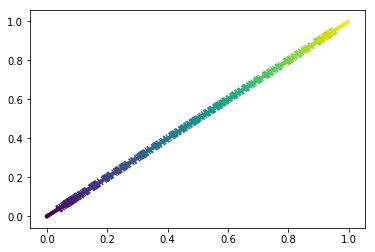

In [16]:
x = svg.generate_from_samples(x_test)
if dataset == 'mnist':
    n_imgs = 10
    # num = 7
    # sub = y_test == num
    sub = y_test == y_test
    for i in range(n_imgs):
        idx = np.random.randint(len(x[sub]))
        plt.subplot(1,2,1)
        plt.imshow(x_test[sub][idx].reshape(28, 28))
        plt.subplot(1,2,2)
        plt.imshow(x[sub][idx].reshape(28, 28))
        plt.figure()
else:
    %matplotlib
    plot(x, y_test, x2=x_test, y2=y_test)

In [ ]:
# get number of neighbors within one standard deviation of each element in x_test
get_distr = K.function([svg.inputs], [svg.sigma, svg.mu])
_sigma, _mu = predict_with_K_fn(get_distr, x_test)
_sigma = np.exp(_sigma)

num_close = []
for i in range(len(_sigma)):
    s, m = _sigma[i,:], _mu[i,:]
    scaled_dists = (_mu - m)/s
    # consider as neighbors all points within the variance of x_i
    less_than_std = np.abs(scaled_dists) < 1
    less_than_std = np.logical_and(less_than_std[:,0], less_than_std[:,1])
    # split neighbors into those of the same class and those of a different class
    same, diff = (y_test[less_than_std] == y_test[i]), (y_test[less_than_std] != y_test[i])
    num_close.append((np.sum(same), np.sum(diff)))

In [ ]:
svg.x_recon

In [19]:
# differentiate decoder with respect to inputs to compute another jacobian, and then evaluate it on the same point
_jacobian = [tf.expand_dims(tf.gradients(svg.x_recon[:,i], svg.x_enc)[0], 1) for i in range(svg.x_recon.shape[1])]
jacobian = tf.reduce_sum(tf.concat(_jacobian, axis=1), axis=0)
B = tf.diag(tf.exp(tf.reduce_sum(svg.sigma, axis=0)) ** 2)
cov = tf.matmul(jacobian, tf.matmul(B, jacobian, transpose_b=True))
cov = tf.reshape(cov, (x_test[0].shape[0], x_test[0].shape[0]))

In [40]:
# create burst from a point and compute covariance matrix
burst_size = 1000
rand_idx = np.random.randint(len(x_test))
x_ = x_test[rand_idx]
x_arr = np.array([x_] * burst_size)
x_rec = svg.generate_from_samples(x_arr)

cov_burst = np.cov((x_rec - np.mean(x_rec, axis=0)).T)

# run gradient burst
# cov_grad = K.get_session().run([svg.x_recon, cov, B, jacobian], feed_dict={svg.input: np.array([x_]*1)})
cov_grad = K.get_session().run([cov], feed_dict={svg.input: np.array([x_]*1)})[0]

In [41]:
cov_grad

array([[4.2140033e-05, 4.2225918e-05],
       [4.2225918e-05, 4.2312946e-05]], dtype=float32)

In [42]:
cov_burst

array([[0.00160175, 0.00160529],
       [0.00160529, 0.00160883]])

In [35]:
l_burst, _ = np.linalg.eig(cov_burst)
l_grad, _ = np.linalg.eig(cov_grad)
print('l_burst:', l_burst, l_burst/l_burst[0])
print('l_grad:', l_grad, l_grad/l_grad[0])

l_burst: [4.44890386e-08 3.43059085e-03] [1.00000000e+00 7.71109235e+04]
l_grad: [1.2267446e-04 5.0271858e-09] [1.000000e+00 4.097989e-05]


In [24]:
cov_grad/np.linalg.norm(cov_grad, 'fro')

array([[0.49850416, 0.4999978 ],
       [0.49999774, 0.50149584]], dtype=float32)

In [25]:
cov_burst/np.linalg.norm(cov_burst, 'fro')

array([[0.50061509, 0.4999955 ],
       [0.4999955 , 0.49939317]])

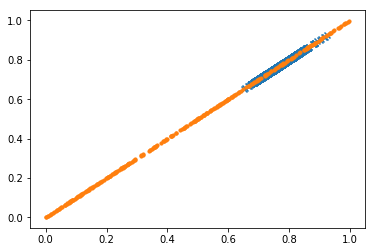

In [26]:
plot(x_rec, x2=x_test)

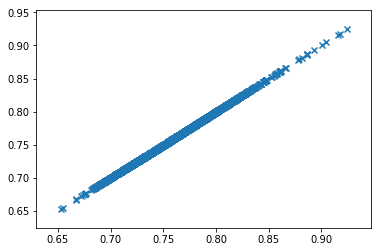

In [27]:
plot(x_rec)

In [55]:
test = np.array([[x for x in range(100)] + [0 for x in range(100)], [0 for x in range(100)] + [x for x in range(100)]])
np.cov(test)

array([[1034.35929648, -615.64070352],
       [-615.64070352, 1034.35929648]])

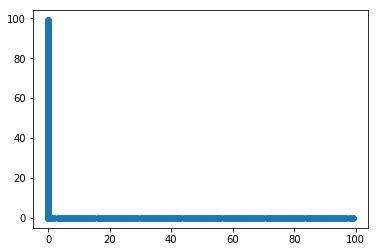

In [56]:
plt.scatter(test[0,:], test[1,:])